In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


> ## Import and examine data

In [30]:
real_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
real_df['label'] = 1
fake_df['label'] = 0
df = pd.concat([real_df, fake_df], axis=0, ignore_index=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


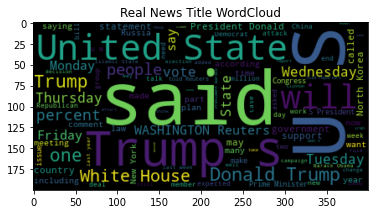

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
plt.figure()
wc= WordCloud(max_words=100, stopwords= STOPWORDS).generate(" ".join(df[df['label']==1]['text']))
plt.title('Real News Title WordCloud')
plt.imshow(wc, interpolation='bilinear')

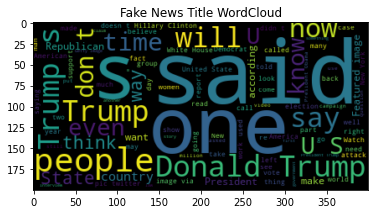

In [34]:
plt.figure()
wc= WordCloud(max_words=100, stopwords= STOPWORDS).generate(" ".join(df[df['label']==0]['text']))
plt.title('Fake News Title WordCloud')
plt.imshow(wc, interpolation='bilinear')

## Preprocess data

In [35]:
import warnings   
warnings.filterwarnings(action = 'ignore') 

import re
import pickle
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [36]:
data = df
data.drop(['title'], inplace=True, axis=1)
data.drop(['subject'], inplace=True, axis=1)
data.drop(['date'], inplace=True, axis=1)
data.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [37]:
def preprocess(df):
    lemmatizer = WordNetLemmatizer()

    text_processed = []
    for text in df.text:
        # remove punctuation and lowercase
        text = re.sub(r'[^a-zA-Z]', ' ', text) 
        text = text.lower()
        
        # tokenize and lemmatize tokens
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(x) for x in tokens]
        text_processed.append(' '.join(tokens))
        
    # token count vectorization
    text_vectorizer = CountVectorizer(stop_words='english', max_features=4000)
    text_matrix = text_vectorizer.fit_transform(text_processed).toarray()
    
    # save vectorizers
    pickle.dump(text_vectorizer, open('text_vectorizer.pkl','wb'))
    
    # store label then drop old text columns and label
    y = np.array(df.label)
    df.drop(['text','label'], inplace=True, axis=1)
    
    # return X, y as np matrices
    return text_matrix, y

In [38]:
X, y = preprocess(data)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31428, 4000)
(13470, 4000)
(31428,)
(13470,)


## Feed-forward Multi-Layer Perceptron

In [41]:
import torch
from torch import nn

In [42]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        # input layer
        self.l1 = nn.Linear(4000, 2000) # input shape (5008,) -> output to layer 2000 units
        self.relu1 = nn.ReLU()
        
        # hidden layer 1
        self.l2 = nn.Linear(2000, 500)  # input shape 2000 -> output to layer 1000 units
        self.relu2 = nn.ReLU()
        
        # hidden layer 2
        self.l3 = nn.Linear(500, 100)    # input shape 500 -> output to layer 100 units
        self.relu3 = nn.ReLU()
        
        # hidden layer 3
        self.l4 = nn.Linear(100, 20)    # input shape 100 -> output to layer 20 units
        self.relu4 = nn.ReLU()
        
        # output layer
        self.l5 = nn.Linear(20, 2)      # input shape 20 -> output layer 2 units (binary classifier)
        
    def forward(self, X):
        out = self.l1(X)
        out = self.relu1(out)
        
        out = self.l2(out)
        out = self.relu2(out)
        
        out = self.l3(out)
        out = self.relu3(out)
        
        out = self.l4(out)
        out = self.relu4(out)
        
        out = self.l5(out)
        return out

## Optimizer and loss function

In [46]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
error = nn.CrossEntropyLoss()
print(model)

MLP(
  (l1): Linear(in_features=4000, out_features=2000, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=2000, out_features=500, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=500, out_features=100, bias=True)
  (relu3): ReLU()
  (l4): Linear(in_features=100, out_features=20, bias=True)
  (relu4): ReLU()
  (l5): Linear(in_features=20, out_features=2, bias=True)
)


## Training

In [47]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).type(torch.LongTensor)

In [48]:
epochs = 20

for epoch in range(epochs):
    
    # clear gradients
    optimizer.zero_grad()
    
    # forward pass
    out = model(X_train)
    
    # compute loss
    loss = error(out, y_train)
    
    # backprop
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # print train loss
    print(f'Epoch {epoch} Loss: {loss}')
    

Epoch 0 Loss: 0.6926311254501343
Epoch 1 Loss: 0.6793360710144043
Epoch 2 Loss: 0.645847499370575
Epoch 3 Loss: 0.5767912268638611
Epoch 4 Loss: 0.473699152469635
Epoch 5 Loss: 0.36623629927635193
Epoch 6 Loss: 0.26669421792030334
Epoch 7 Loss: 0.20582792162895203
Epoch 8 Loss: 0.16740365326404572
Epoch 9 Loss: 0.13217757642269135
Epoch 10 Loss: 0.10811082273721695
Epoch 11 Loss: 0.0971999540925026
Epoch 12 Loss: 0.08236923813819885
Epoch 13 Loss: 0.07210023701190948
Epoch 14 Loss: 0.07055415213108063
Epoch 15 Loss: 0.06058511510491371
Epoch 16 Loss: 0.049118492752313614
Epoch 17 Loss: 0.04641128331422806
Epoch 18 Loss: 0.03563832491636276
Epoch 19 Loss: 0.03337385877966881


## Evaluate model

In [50]:
from sklearn.metrics import accuracy_score
y_pred = model(X_test)
y_pred_max = torch.max(y_pred,1)[1]
test_accuracy = accuracy_score(y_pred_max, y_test)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.9864884929472902


In [52]:
import pickle
pickle.dump(model, open('model2.pkl', 'wb'))